<a href="https://colab.research.google.com/github/alapatijahnavi/FMML/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-12 07:49:37--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.31, 13.225.4.109, 13.225.4.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  76.7MB/s    in 0.6s    

2024-05-12 07:49:38 (76.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


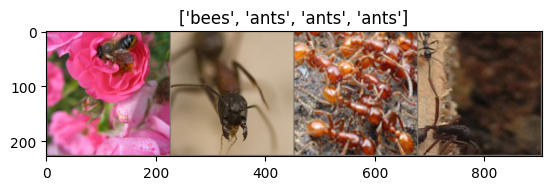

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [11]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5998 Acc: 0.7623

Epoch 1/4
----------
Loss: 0.5967 Acc: 0.7828

Epoch 2/4
----------
Loss: 0.4537 Acc: 0.8320

Epoch 3/4
----------
Loss: 0.3214 Acc: 0.8770

Epoch 4/4
----------
Loss: 0.6037 Acc: 0.8033



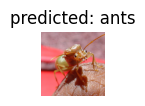

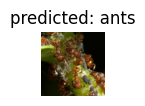

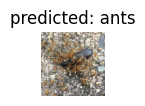

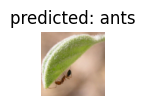

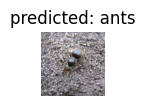

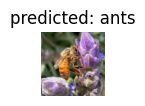

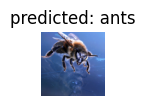

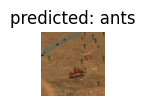

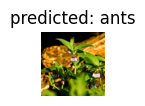

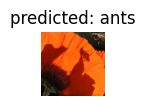

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


# **1 ANS**

Data augmentations, such as resizing, cropping, rotation, flipping, and adding noise to images, play a crucial role in training deep learning models, especially in scenarios with limited training data. Here's why they are significant:

Increased Variability: Augmentations introduce variations of the original data, which helps in exposing the model to a wider range of scenarios it might encounter during inference. This increased variability can improve the model's generalization performance.

Regularization: Augmentations act as a form of regularization by adding noise to the training process. This helps prevent overfitting by discouraging the model from relying too much on specific features of the training data.

Robustness to Input Variations: Models trained with augmented data tend to be more robust to variations in the input data, such as changes in lighting conditions, viewpoint, or orientation. This robustness is particularly important in real-world applications where the test data may differ from the training data.

Data Efficiency: Augmentations allow us to generate additional training samples without collecting new data manually. This is especially beneficial when the available dataset is small, as it effectively expands the dataset size and can lead to better model performance.

Adaptation to Deployment Conditions: Augmentations can help the model adapt to different deployment conditions. For example, resizing and cropping can simulate variations in image resolution or aspect ratio that the model may encounter in production.

Reduced Bias: Augmentations can help mitigate biases present in the original dataset by creating more diverse representations of the data. This can lead to fairer and more inclusive models.

# **2 ANS**

If you don't use a pretrained ResNet model and train the model from scratch (by setting pretrained=False), the performance of the model may be significantly affected. Here's why:

Feature Learning: Pretrained models like ResNet have been trained on large datasets (e.g., ImageNet) and have learned rich feature representations through millions of iterations. When you use a pretrained model, you're essentially leveraging these prelearned features, which can be beneficial, especially when you have a limited training dataset.

Generalization: Pretrained models often generalize well to unseen data because they have learned to extract features that are useful for a wide range of tasks. Training from scratch might require a larger dataset and longer training time to achieve comparable generalization performance.

Computational Cost: Training a deep neural network from scratch is computationally expensive and time-consuming, especially for complex architectures like ResNet. Utilizing a pretrained model can save significant computational resources because you're starting with parameters that are already tuned to recognize various patterns in images.

Risk of Overfitting: Training from scratch increases the risk of overfitting, especially when the dataset is small. Pretrained models, on the other hand, have been regularized during training on large datasets, which helps prevent overfitting.

Task-Specific Learning: While pretrained models provide a good starting point for transfer learning, fine-tuning the model on a task-specific dataset (possibly with some frozen layers) allows the model to adapt to the nuances of the new dataset, potentially leading to improved performance.

# **3 ANS**

Using a ResNet model pretrained on a dataset significantly different from the ants vs bees data may still yield good performance, although the extent of performance improvement may vary depending on several factors:

Transferability of Features: Pretrained models are often trained on large, diverse datasets like ImageNet, which contain a wide variety of objects and scenes. Despite the differences between the pretrained dataset and the target dataset (ants vs bees), the lower layers of the pretrained model likely capture low-level features such as edges, textures, and basic shapes, which are generally transferrable across domains.

Fine-Tuning: Fine-tuning the pretrained model on the target dataset can help adapt its learned representations to better suit the specific characteristics of the new data. By updating the model parameters during fine-tuning, the model can learn to extract features that are more relevant to the ants vs bees classification task.

Amount of Training Data: The availability of training data plays a crucial role in determining the effectiveness of transfer learning. If the ants vs bees dataset is small, transfer learning with a pretrained model can still provide a significant performance boost by leveraging the knowledge encoded in the pretrained weights.

Domain Similarity: The performance of transfer learning also depends on the similarity between the source domain (pretrained dataset) and the target domain (ants vs bees dataset). While the datasets may differ significantly in terms of specific classes or contexts, there may still be shared visual characteristics that are beneficial for feature transfer.

Model Capacity: The capacity of the pretrained model relative to the complexity of the target task is another important factor. If the pretrained model is sufficiently large and expressive, it may have the capacity to learn representations that are useful for the ants vs bees classification task, even if the pretrained dataset is different.

